# Demonstrating the importance of weighting functions in SOAP
The idea is to generate a simple system and test how sensitive SOAP is (with and without the weighting function) from one atom to another.

Importing required packages

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import dscribe
from ase.build import molecule
from dscribe.descriptors import SOAP
from ase.build import bulk
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.cube import read_cube, write_cube
from sklearn.metrics import explained_variance_score, mean_squared_error
import os
import sys
import py3Dmol
import numpy as np
import random
sys.path.append('deepcdp/')
from deepcdp import deepcdp
import sklearn.metrics as skmetrics
from sklearn.neural_network import MLPRegressor
import time
import pickle

Let's create a fcc Cu with just two atoms

In [2]:
# We will use ase's bulk function. Set up an orthorhombic cell. 
copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
cut = np.sqrt(1.8**2 + 1.8**2)
cut = copper_ortho.get_distance(0,1)
# cut off radius for SOAP. Not essential
print(fr'{cut: 1.2f} Angs.')

 2.55 Angs.


Generating the SOAP function with DScribe. Our SOAP is coded to be periodic along all three dimensions.

In [3]:
rcut = 2.54*3 # Local cut off
nmax = 8 # max number of radial basis functions
lmax = 8 # maximum degree of spherical harmonics

copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
print('Periodic = ',copper_ortho.get_pbc()) # checking for 
copper_soap_noW = SOAP( # noW = no weight
    species=[29],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    periodic=True,
    sparse=False
)

Periodic =  [ True  True  True]


Viewing this system.

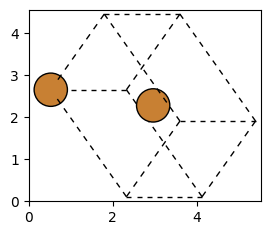

In [4]:
# view(copper_ortho, viewer='x3d') # uncomment this if you want to have an interactive view
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(copper_ortho, ax, radii=0.3, rotation=('45x,45y,0z'))
plt.savefig('Images/Cu-cartoon.png',dpi=400)
# plt.show()


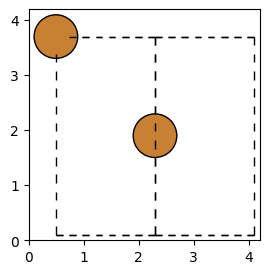

In [5]:
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(copper_ortho, ax, radii=0.3, rotation=('90x,45y,0z'))
plt.show()

Our task is to first sample few points (linearly) from one Cu atom to another. We then calculate the SOAP vectors for each of these points using our SOAP function. 

Let's pick seven such points, where the starting and the ending points are the two atom centers, respectively. 

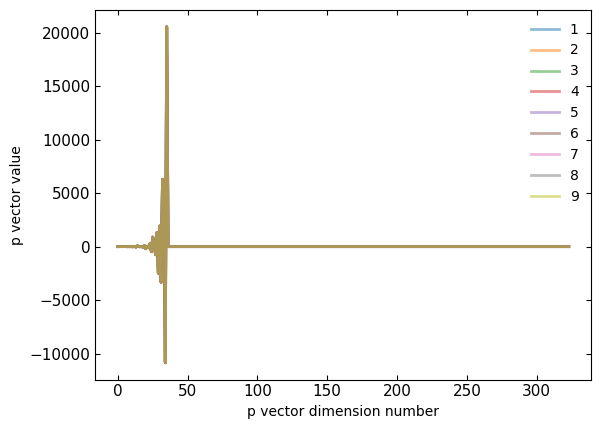

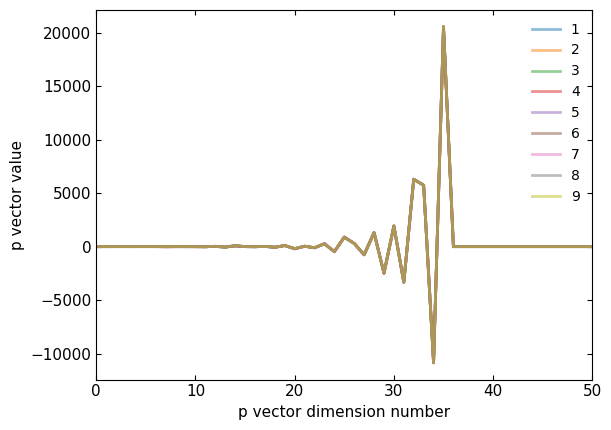

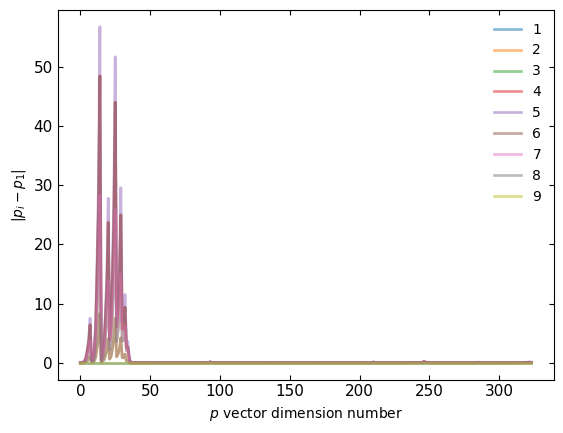

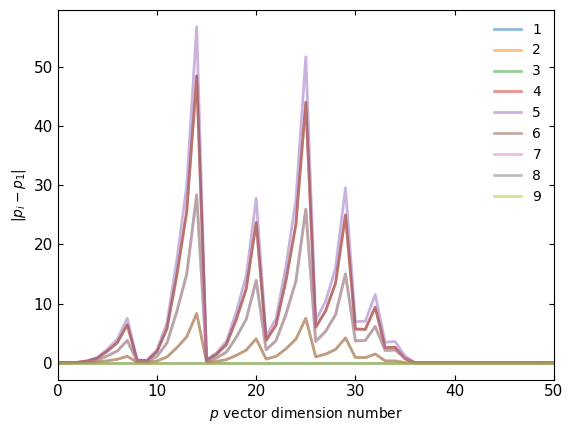

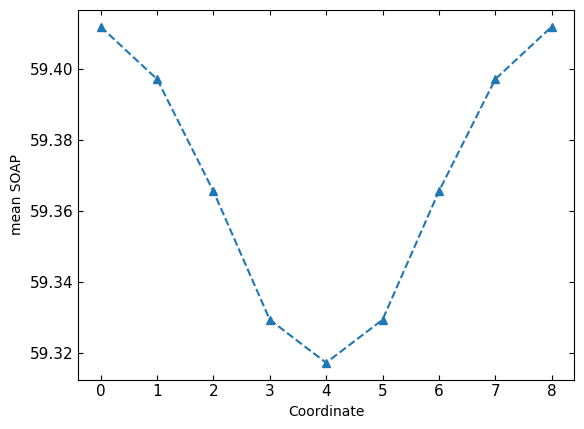

In [27]:
# Creating an points to multiply position vectors
multiplier = np.arange(0,1125,125)/1000 

# all position vectors from one Cu atom to another 
pos_vector = [(copper_ortho.get_positions()[1])*m 
              for m in multiplier]

# generating soap for each point
soap_copper_ortho = copper_soap_noW.create(copper_ortho,
                                         positions = pos_vector)
# plotting and storing the mean soap value
mean_soap = []
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
#              label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
             label = i+1,
            alpha=0.5,
            linewidth=2)
    mean_soap += [np.mean(soap_copper_ortho[i])]
plt.xlabel('p vector dimension number')
plt.ylabel('p vector value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)

plt.show()

# plotting only the zoomed in section

# plt.figure(figsize=(6,3))
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
#              label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
             label = i+1,
            alpha=0.5,
            linewidth=2)
plt.xlabel('p vector dimension number',size=11)
plt.ylabel('p vector value',size=11)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.xlim(0,50)
plt.show()

# plotting the absolute deviation of soap vectors w.r.t soap at 0,0,0
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    diff=soap_copper_ortho[i]-soap_copper_ortho[0]
    plt.plot(np.abs(diff),
#              label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
             label = i+1,
            alpha=0.5,
            linewidth=2)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.xlabel(f'$p$ vector dimension number')
plt.ylabel(f'|$p_i - p_1$|')
plt.show()

# plotting the absolute deviation of soap vectors w.r.t soap at 0,0,0
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    diff=soap_copper_ortho[i]-soap_copper_ortho[0]
    plt.plot(np.abs(diff),
#              label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
             label = i+1,
            alpha=0.5,
            linewidth=2)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.xlabel(f'$p$ vector dimension number')
plt.ylabel(f'|$p_i - p_1$|')
plt.xlim(0,50)
plt.show()

# plotting mean soap value 
plt.plot(mean_soap,'^--')
plt.ylabel('mean SOAP')
plt.xlabel('Coordinate')
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

In [422]:
# sensitvity score
# Compute the pairwise distances between the vectors
distances = skmetrics.euclidean_distances(soap_copper_ortho[0:5,0:100])

# Compute the minimum distance between each pair of vectors
min_distances = np.min(distances[np.nonzero(distances)])

print(min_distances)

# Compute the sensitivity score
sensitivity = min_distances / np.max(soap_copper_ortho[0:5,0:100])

print("Sensitivity score:", sensitivity)

15.15604570388749
Sensitivity score: 0.0007376574794408266


In [420]:
distances[np.nonzero(distances)], distances

(array([ 15.1560457 ,  52.54178844,  88.90270109, 104.54663916,
         15.1560457 ,  37.40614042,  73.74991069,  89.39823948,
         52.54178844,  37.40614042,  36.40181345,  52.01651987,
         88.90270109,  73.74991069,  36.40181345,  15.67692117,
        104.54663916,  89.39823948,  52.01651987,  15.67692117]),
 array([[  0.        ,  15.1560457 ,  52.54178844,  88.90270109,
         104.54663916],
        [ 15.1560457 ,   0.        ,  37.40614042,  73.74991069,
          89.39823948],
        [ 52.54178844,  37.40614042,   0.        ,  36.40181345,
          52.01651987],
        [ 88.90270109,  73.74991069,  36.40181345,   0.        ,
          15.67692117],
        [104.54663916,  89.39823948,  52.01651987,  15.67692117,
           0.        ]]))

<BarContainer object of 9 artists>

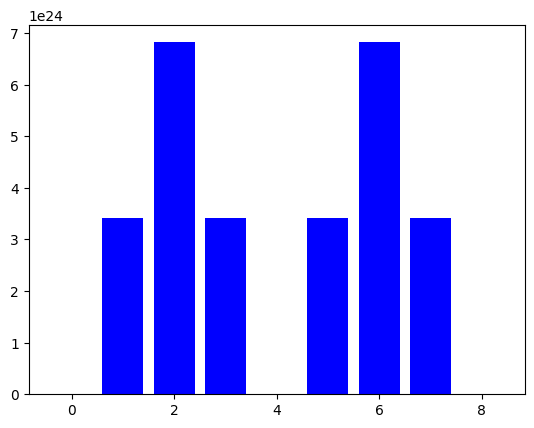

In [346]:
mean_abs_dev_noW = np.ma.masked_invalid(abs(soap_copper_ortho[0]- soap_copper_ortho)/soap_copper_ortho[0]).mean(axis=1)
plt.bar(np.arange(len(soap_copper_ortho)), mean_abs_dev_noW, color='blue')

What we observe is that these SOAP vectors (p values) do not appear to be too sensitive to the location the point in space. We do see a trend in the mean SOAP plot, but the overall magnitude of these vectors are similar to each other over the different features. 

Let's see what happens when we include a weighting function (like the polynomial weighting).

In [6]:
rcut = 2.54*3 # Local cut off
nmax = 8 # max number of radial basis functions
lmax = 8 # maximum degree of spherical harmonics

copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
print('Periodic = ',copper_ortho.get_pbc()) # checking for periodicity in ase

copper_soap_W = SOAP( # W = with weighting
    species=[29],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    sigma=1,
    periodic=True,
    sparse=False,
    weighting={"function":"poly","r0":2,"c":2,"m":2}
)

Periodic =  [ True  True  True]


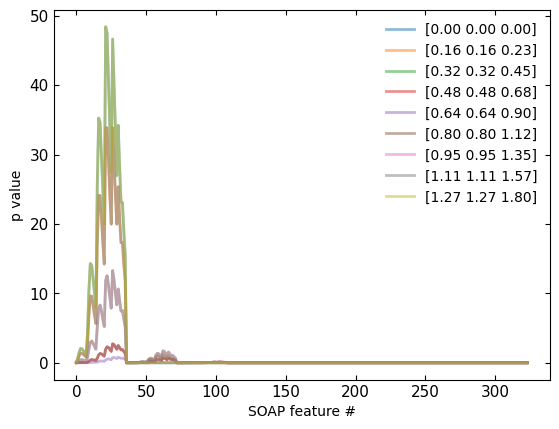

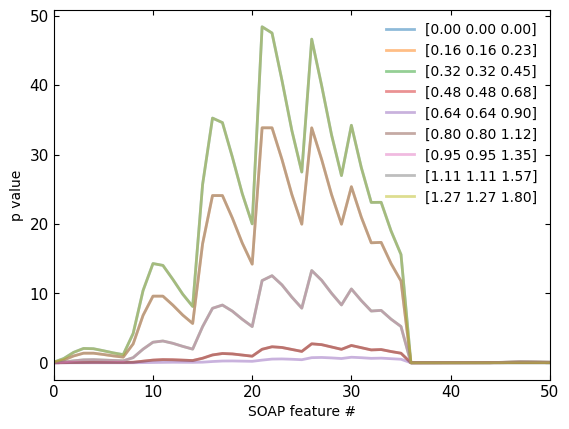

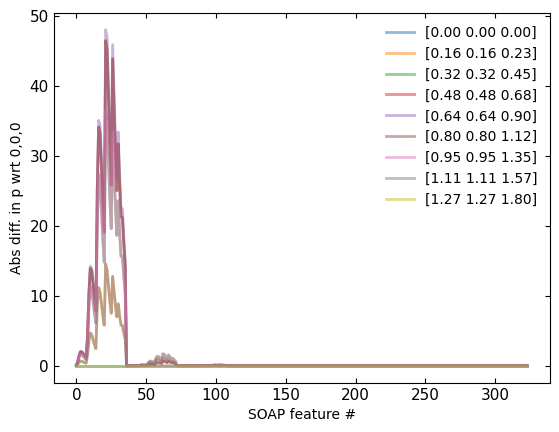

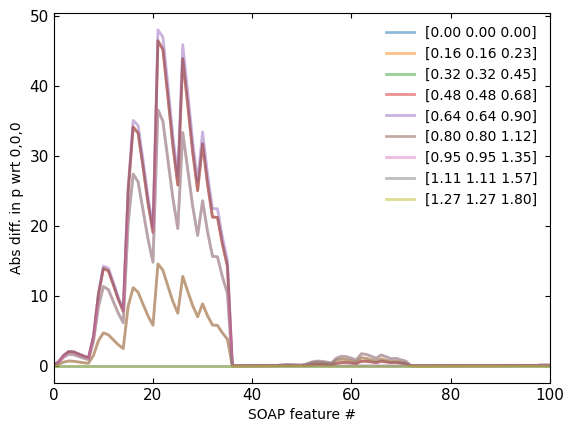

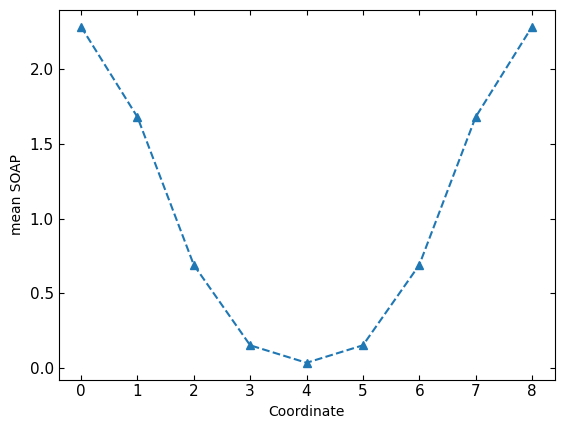

In [423]:
# Creating an points to multiply position vectors
multiplier = np.arange(0,1125,125)/1000 

# all position vectors from one Cu atom to another 
pos_vector = [(copper_ortho.get_positions()[1])*m 
              for m in multiplier]

# generating soap for each point
soap_copper_ortho = copper_soap_W.create(copper_ortho,
                                         positions = pos_vector)
# plotting and storing the mean soap value
mean_soap = []
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
    mean_soap += [np.mean(soap_copper_ortho[i])]
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

# plotting only the zoomed in section
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_copper_ortho[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.xlim(0,50)
plt.show()

# plotting the absolute deviation of soap vectors w.r.t soap at 0,0,0
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    diff=soap_copper_ortho[i]-soap_copper_ortho[0]
    plt.plot(np.abs(diff),label =f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.ylabel('Abs diff. in p wrt 0,0,0')
plt.xlabel('SOAP feature #')
plt.show()

# plotting the absolute deviation of soap vectors w.r.t soap at 0,0,0
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    diff=soap_copper_ortho[i]-soap_copper_ortho[0]
    plt.plot(np.abs(diff),label =f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.ylabel('Abs diff. in p wrt 0,0,0')
plt.xlabel('SOAP feature #')
plt.xlim(0,100)
plt.show()

# plotting mean soap value 
plt.plot(mean_soap,'^--')
plt.ylabel('mean SOAP')
plt.xlabel('Coordinate')
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

In [424]:
# sensitvity score
# Compute the pairwise distances between the vectors
distances = skmetrics.euclidean_distances(soap_copper_ortho[0:5,0:100])

# Compute the minimum distance between each pair of vectors
min_distances = np.min(distances[np.nonzero(distances)])

print(min_distances)

# Compute the sensitivity score
sensitivity = min_distances / np.max(soap_copper_ortho[0:5,0:100])

print("Sensitivity score:", sensitivity)

6.49992816379788
Sensitivity score: 0.13430286563977384


/var/folders/8p/6t_fjn5d1c7fxwflz29kdvqr0000gn/T/ipykernel_96878/2476318050.py:2: RuntimeWarning: divide by zero encountered in divide
  mean_abs_dev_W = np.ma.masked_invalid(abs(soap_copper_ortho[0]- soap_copper_ortho)/soap_copper_ortho[0]).mean(axis=1)
/var/folders/8p/6t_fjn5d1c7fxwflz29kdvqr0000gn/T/ipykernel_96878/2476318050.py:2: RuntimeWarning: invalid value encountered in divide
  mean_abs_dev_W = np.ma.masked_invalid(abs(soap_copper_ortho[0]- soap_copper_ortho)/soap_copper_ortho[0]).mean(axis=1)


<BarContainer object of 9 artists>

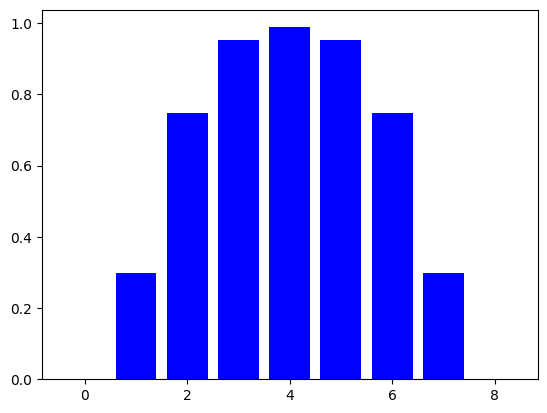

In [344]:
# calculating mean absolute percentage error for each point
mean_abs_dev_W = np.ma.masked_invalid(abs(soap_copper_ortho[0]- soap_copper_ortho)/soap_copper_ortho[0]).mean(axis=1)
plt.bar(np.arange(len(soap_copper_ortho)), mean_abs_dev_W, color='blue')

There is more sentivity with the inclusion of weights, when compared to without. However, this does not indicate if the sensitivity provided by using this polynomial weighting function.

We will use a modest training set of six snapshots. The training data was generated for Cu fcc with 2 atoms in the cell. Let's first build a model using the non-weighted SOAP function. We will be using the MLPRegressor function in sklearn for convinience.

In [28]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/bulk-Cu/'
datafilename = 'Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']

data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']

cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP_noW=deepcdp(copper_soap_noW)

# generates a box of points. Be mindful of the gamma value used.
CDP_noW.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP_noW.generate_cube_data(data_files_sub,cubefile,sampleSubs)


NameError: name 'data_files' is not defined

The CDP_noW object stores the training X (SOAP) and Y (densities). 

In [155]:
CDP_noW.trainX.shape, int(CDP_noW.trainX.shape[0]/6), CDP_noW.trainY.shape, 

((51750, 324), 8625, (51750,))

There are a total of 31050 points samples from these 6 images. Each image contains 5175 points. The SOAPs correspond to 324 features. Let's use this data to train a model. 

In [3]:
114/13

8.76923076923077

In [154]:
# training a model
start = time.time()
model_Cu_noW = MLPRegressor(hidden_layer_sizes=(300,300,300),
                           random_state=1,
                           max_iter=300, 
                           shuffle=True,
                          batch_size=500,
                         ).fit(CDP_noW.trainX, 
                               CDP_noW.trainY) 
end = time.time()
print("Training: ", (end - start), " seconds.")

Training:  114.30640006065369  seconds.


In [159]:
file_name = 'sample-models/bulk-cu/cu_noW.sav'
pickle.dump(model_Cu_noW, open(file_name,'wb'))

In [425]:
# Testing 0 Cu structure
test_cube_path = 'data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = copper_soap_W.create(ase_atoms_test, positions=CDP_noW.box)
rho_pred = model_Cu_noW.predict(soap_test)

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')

Prediction time:  2.8246068954467773  seconds.
R2 value: 0.62
MSE value: 0.04778


For a sample cube file, we get a prediction R2 value of 0.62.

In [426]:
out=open('example/predictions/bulk-cu/pred-0_noW.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP_noW.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP_noW.box[0])

In [427]:
cu_cube_predict=open('example/predictions/bulk-cu/pred-0_noW.cube').read()
cu_cube_dft=open(test_cube_path).read()
CDP_noW.cube2xyz(test_cube_path,'example/structures/bulk-cu/cu-0.xyz')
cu_xyz=open('example/structures/bulk-cu/cu-0.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_cube_predict,'cube',{'isoval': 0.3,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(cu_cube_dft,'cube',{'isoval': 0.3,"color":'grey','opacity':1,'wireframe':True})
# xyzview.addModel(cu_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Comparing the difference between the two electron density predictions

In [428]:
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/bulk-cu/error-0_noW.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP_noW.box[0])

In [429]:
cu_error_predict=open('example/predictions/bulk-cu/error-0_noW.cube').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_error_predict,'cube',{'isoval': 0.3,"color":'blue','opacity':1,'wireframe':False})
# xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

It is obvious that the model does not perform well. Let's try to integrate the densities along the z axis and then plot 2D contours.

In [430]:
# fixing vmin and vmax
vmax = 11
vmin = 3

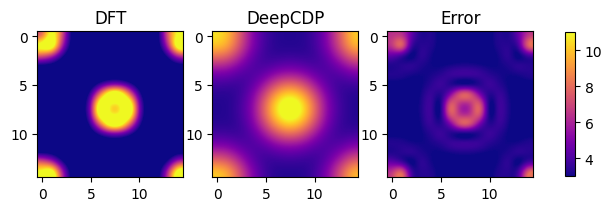

In [435]:
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=3, vmax=11)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
# plt.savefig('Images/Cu-soap-without-weights.png',dpi=600,bbox_inches="tight",)

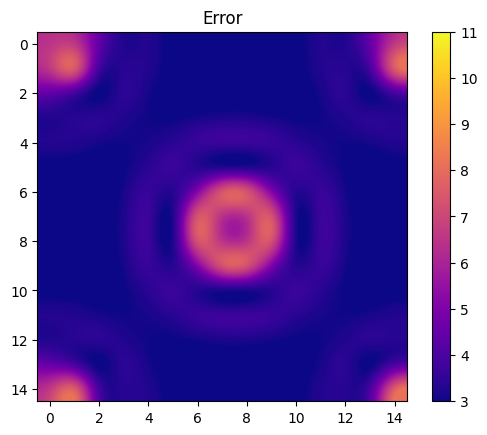

In [282]:
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36',vmin=vmin, vmax=vmax)
plt.title('Error')
plt.colorbar()
plt.show()

## Training model using weighting function

Let's now generate a model using the weighted-SOAP function for Cu. 

In [141]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/bulk-Cu/'
datafilename = 'Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']

data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']

cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP_W=deepcdp(copper_soap_W)

# generates a box of points. Be mindful of the gamma value used.
CDP_W.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP_W.generate_cube_data(data_files_sub,cubefile,sampleSubs)


[145, 67, 450, 387, 220, 200, 82, 0, 300, 2, 130, 259]
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_259.cube
SOAP is of dimension: (5175, 324)
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_200.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_2.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_450.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_67.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_130.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_82.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_145.cube


(array([[3.54132154e-02, 2.46856273e-01, 6.31376090e-01, ...,
         5.07052271e-14, 7.54875900e-14, 1.12382422e-13],
        [3.57500822e-02, 2.49187463e-01, 6.37091078e-01, ...,
         4.69474209e-14, 6.98716806e-14, 1.03989775e-13],
        [2.89146835e-02, 2.01849258e-01, 5.20584341e-01, ...,
         2.18894813e-13, 3.28034883e-13, 4.91591751e-13],
        ...,
        [6.62404058e-02, 4.59620815e-01, 1.14608152e+00, ...,
         1.20459403e-12, 3.20712639e-12, 8.53869616e-12],
        [7.30457719e-02, 5.06469837e-01, 1.25799722e+00, ...,
         6.92156773e-17, 1.99921145e-16, 5.77911558e-16],
        [6.43730933e-02, 4.46759149e-01, 1.11527719e+00, ...,
         1.41658095e-17, 2.06882527e-17, 3.02138610e-17]]),
 array([0.88537, 0.90186, 0.66121, ..., 2.5005 , 2.6162 , 2.3735 ]))

In [142]:
# training a model
start = time.time()
model_Cu_W = MLPRegressor(hidden_layer_sizes=(300,300,300),
                           random_state=1,
                           max_iter=300, 
                           shuffle=True,
                          batch_size=500,
                         ).fit(CDP_W.trainX, 
                               CDP_W.trainY) 
end = time.time()
print("Training: ", (end - start), " seconds.")

Training:  87.03382921218872  seconds.


In [162]:
file_name = 'sample-models/bulk-cu/cu_W.sav'
pickle.dump(model_Cu_W, open(file_name,'wb'))

In [373]:
# Testing 0 Cu structure
test_cube_path = 'data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = copper_soap_W.create(ase_atoms_test, positions=CDP_W.box)
rho_pred = model_Cu_W.predict(soap_test)

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')


Prediction time:  3.6644411087036133  seconds.
R2 value: 0.98
MSE value: 0.00248


In [374]:
out=open('example/predictions/bulk-cu/pred-0.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP_W.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP_W.box[0])

In [375]:
cu_cube_predict=open('example/predictions/bulk-cu/pred-0.cube').read()
cu_cube_dft=open(test_cube_path).read()
CDP_W.cube2xyz(test_cube_path,'example/structures/bulk-cu/cu-0.xyz')
cu_xyz=open('example/structures/bulk-cu/cu-0.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_cube_predict,'cube',{'isoval': 0.3,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(cu_cube_dft,'cube',{'isoval': 0.3,"color":'grey','opacity':1,'wireframe':True})
# xyzview.addModel(cu_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [376]:
rho_test_resp.shape
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/bulk-cu/error-0_W.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP_noW.box[0])

In [377]:
cu_error_predict=open('example/predictions/bulk-cu/error-0_W.cube').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_error_predict,'cube',{'isoval': 0.3,"color":'blue','opacity':1,'wireframe':False})
# xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

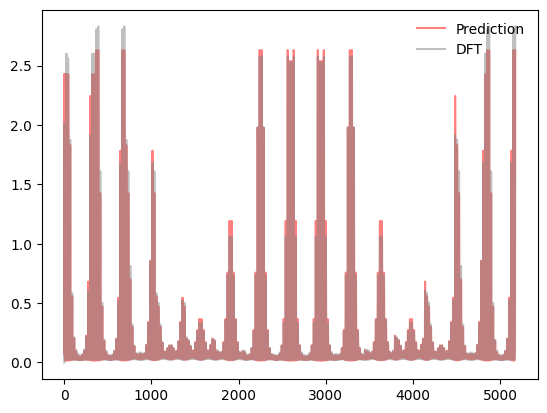

In [378]:
plt.plot(rho_test_resp.flatten(), color='red',label='Prediction',alpha=0.5)
plt.plot(rho_test.flatten(), color='grey', label='DFT',alpha=0.5)
plt.legend(frameon=False)
plt.show()

These prediction errors are tiny compared to the non weighted case.  

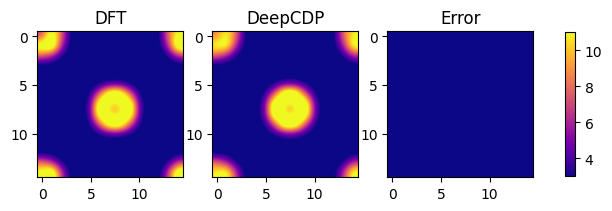

In [380]:
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
plt.savefig('Images/Cu-soap-with-weights.png',dpi=600,bbox_inches="tight",)

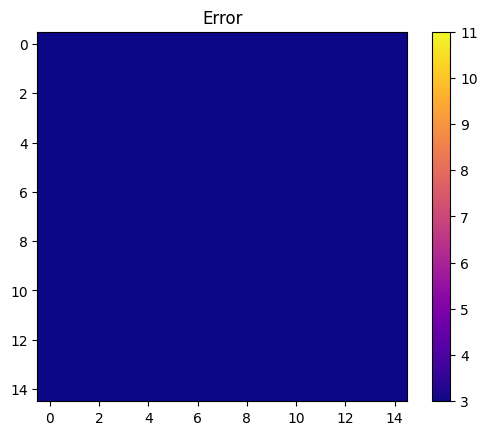

In [290]:
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36',vmin=vmin, vmax=vmax)
plt.title('Error')
plt.colorbar()
plt.show()